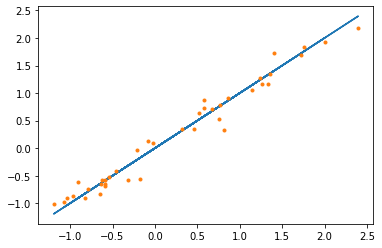

In [7]:
from casadi import *
import numpy as np
import pandas as pd
from numpy.linalg import norm
import sADMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

raw = pd.read_csv("CCPP.csv") 
# scale data to have zero mean and std = 1
scaler = StandardScaler()
data = scaler.fit_transform(raw)

x = data[0:40,0:4]
#x['bias'] = np.ones(x.shape[0])
#x = x.to_numpy()

y = data[0:40,4]
#y = y.to_numpy()
y = y.reshape(-1,1)

nu = 4                     # no. of inputs
ny = 1                     # no. of outputs
nn = 5                     # no. of neurons 
nw =  nu*nn+nn+ny*nn+ny    # no. of parameters

# Solve centralized optimization
solver,nlp = sADMM.MLP_regression(x,y,nn)
Primal,Dual,f = sADMM.solvenlp(solver,nlp)
w_opt = Primal.full()

# Prediction
y_pred0 = sADMM.MLP(x,w_opt,4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')



In [12]:

N = 4
nData,ny = y.shape
nblock = round(nData/N)

# Split data into N data chunks
x1 = x[0*nblock:1*nblock,:]
x2 = x[1*nblock:2*nblock,:]
x3 = x[2*nblock:3*nblock,:] 
x4 = x[3*nblock:4*nblock,:]

y1 = y[0*nblock:1*nblock,:] 
y2 = y[1*nblock:2*nblock,:]
y3 = y[2*nblock:3*nblock,:] 
y4 = y[3*nblock:4*nblock,:]

rho = 100 # penalty term in the Augmented Lagrangian


solver0,nlp0 = sADMM.consensus_reg_nn(nw,N,rho)

solver1,nlp1 = sADMM.consensus_subproblem_nn(x1,y1,nn,rho)
solver2,nlp2 = sADMM.consensus_subproblem_nn(x2,y2,nn,rho)
solver3,nlp3 = sADMM.consensus_subproblem_nn(x3,y3,nn,rho)
solver4,nlp4 = sADMM.consensus_subproblem_nn(x4,y4,nn,rho)

solvers = [solver1,solver2,solver3,solver4]
nlps = [nlp1,nlp2,nlp3,nlp4]

np.random.seed(12)
xinit = np.random.rand(nw,1)

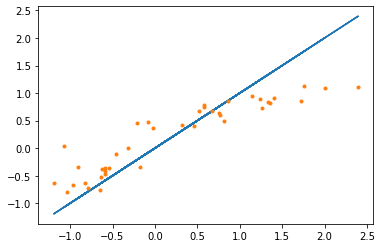

In [13]:

x0_opt = xinit#w_opt*0.05    # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt,dL,r_prml,r_dual = sADMM.ADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0000002,MaxIter=30)

# Prediction
xavg = 0
for i in range(0,len(solvers)):
    xavg +=x_opt[i]
xavg+= x0_opt
xavg = xavg/5

y_pred0 = sADMM.MLP(x,xavg.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')


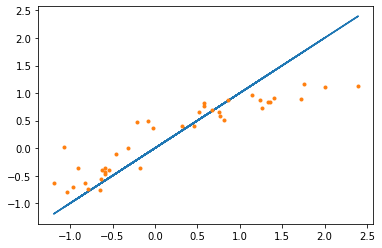

In [14]:
x0_opt = xinit   # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt,r_prml1,r_dual1,r_app  = sADMM.sADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0000002,MaxIter=30)

# Prediction
xavg = 0
for i in range(0,len(solvers)):
    xavg +=x_opt[i]
xavg+= x0_opt
xavg = xavg/5

y_pred0 = sADMM.MLP(x,xavg.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

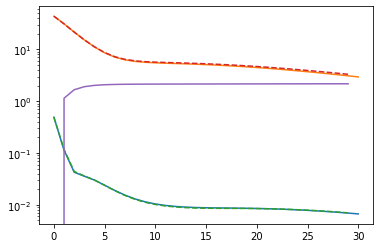

In [20]:
plt.plot(r_prml)
plt.plot(r_dual)
plt.plot(r_prml1[1:-1],'--')
plt.plot(r_dual1[1:-1],'--')
plt.yscale("log")
plt.plot(r_app[1:-1])

In [6]:
x0_opt = xinit#w_opt*0.05   # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt,r_prml2,r_dual2 = sADMM.stochastic_sADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0000002,MaxIter=30,delta = 0.1)

# Prediction
y_pred0 = sADMM.MLP(x,x0_opt.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

ValueError: too many values to unpack (expected 2)

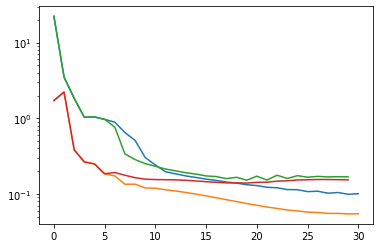